# ttt_smooth_column

In [1]:
#source /export/ciao/bin/ciao.bash -o
PFILES="./param;$ASCDS_INSTALL/param:$ASCDS_INSTALL/contrib/param"
mkdir -p ./param
ASCDS_WORK_PATH=./


---


In [2]:
/bin/rm -rf 14382
download_chandra_obsid 14382 mtl
mv -fv 14382/secondary/*fits.gz .
gunzip -f *fits.gz
rmdir -p 14382/secondary


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  mtl      fits      411 Kb  ####################          < 1 s  13636.5 kb/s

'14382/secondary/acisf14382_000N002_mtl1.fits.gz' -> './acisf14382_000N002_mtl1.fits.gz'


In [3]:
dmtcalc acisf14382_000N002_mtl1.fits"[cols time,fp_temp]" \
    fptemp.fits exp="time=time-tstart"  clob+

## Plot raw data


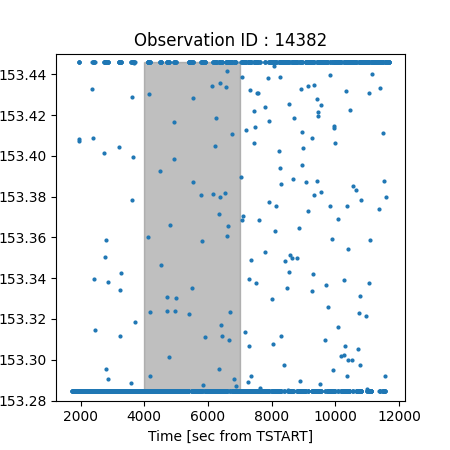

In [4]:
cat << EOM > c1.py
from pycrates import read_file
import matplotlib.pylab as plt

tab = read_file("fptemp.fits")
tt = tab.get_column("time").values
temp = tab.get_column("fp_temp").values
plt.figure(figsize=(4.5,4.5))
plt.plot(tt,temp,linestyle="", marker="o", markersize=2)
plt.xlabel("Time [sec from TSTART]" )
plt.ylabel("Focal Plane Temperature [K]") 
plt.title("Observation ID : 14382" )
m = max(temp)
n = min(temp)
plt.ylim(153.28,153.45)
plt.fill( [4000, 7000, 7000, 4000], [n, n, m, m], color="grey", alpha=0.5 )
plt.savefig("chips_01.png")
EOM

python c1.py
display < chips_01.png


In [5]:
# A little helper to make plotting easier for this notebook

PlotFile()
{
infile="$1"
outfile="$2"
title="$3"

cat << EOM > ${outfile}.py

from pycrates import read_file
import matplotlib.pylab as plt

tab = read_file("${infile}")
tt = tab.get_column(0).values
temp = tab.get_column(1).values

plt.figure(figsize=(4.5,4.5))
plt.plot(tt,temp,linestyle="", marker="o", markersize=2)
plt.xlabel("Time [sec from TSTART]" )
plt.ylabel("Focal Plane Temperature [K]") 
plt.title("Observation ID : 14382 "+"${title}" )
plt.xlim( 4000, 7000) 
plt.ylim(153.28,153.45)
plt.savefig("${outfile}")
EOM

python ${outfile}.py
display < $outfile

}

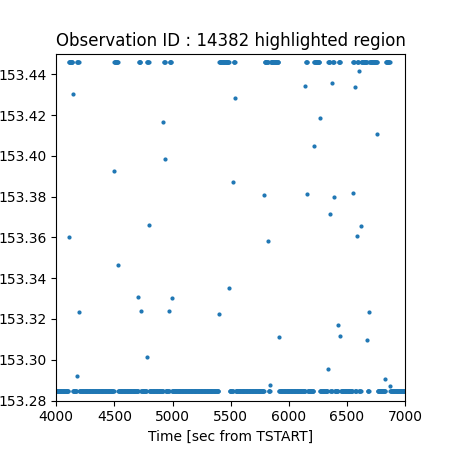

In [6]:
PlotFile "fptemp.fits[cols time,fp_temp]" chips_02.png "highlighted region"

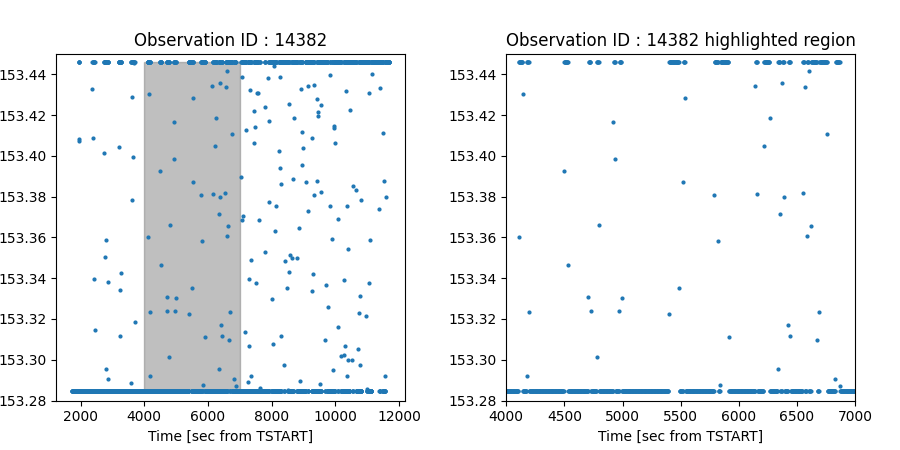

In [7]:
montage chips_01.png chips_02.png -geometry 450x450 raw.png
display < raw.png

## Linear Smoothing

### Box

In [8]:
pset aconvolve infile="fptemp.fits[cols time,fp_temp]" 
pset aconvolve outfile=mean_fptemp.fits 
pset aconvolve kernelspec="lib:box(1,1,51)"  
pset aconvolve meth=slide edge=nearest norm=area clob+
aconvolve mode=h 

PlotFile "mean_fptemp.fits" chips03.png ", 51 point box smooth"

### Gaus

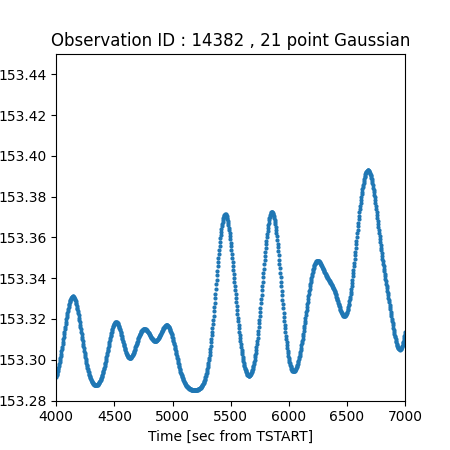

In [9]:
aconvolve fptemp.fits"[cols time,fp_temp]" gaus21_fptemp.fits \
  kernelspec="lib:gaus(1,5,1,21)" meth=slide edge=nearest clob+

PlotFile gaus21_fptemp.fits chips_04.png ", 21 point Gaussian"

In [10]:
aconvolve fptemp.fits"[cols time,fp_temp]" gaus51_fptemp.fits \
  kernelspec="lib:gaus(1,5,1,51)" meth=slide edge=nearest clob+

PlotFile gaus51_fptemp.fits chips_06.png ", 51 point Gaussian"

In [11]:
montage chips_04.png chips_06.png -geometry 450x450 aconvolve_gaus.png
display < aconvolve_gaus.png

## Non Linear Filters

In [12]:
pset dmtabfilt dmtabfilt infile=fptemp.fits 
pset dmtabfilt out=temp_out
pset dmtabfilt col=fp_temp 
pset dmtabfilt function=olympic 
pset dmtabfilt mask=")101"
dmtabfilt mode=h clob+

In [13]:
dmlist temp_out cols

 
--------------------------------------------------------------------------------
Columns for Table Block temp_out
--------------------------------------------------------------------------------
 
ColNo  Name                 Unit        Type             Range
   1   fp_temp_olympic                   Real8          -Inf:+Inf            Smoothed version of column


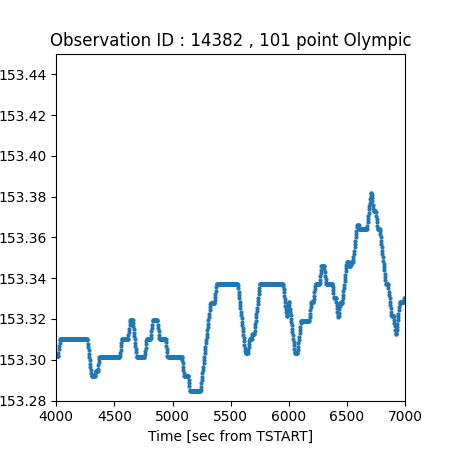

In [14]:
dmpaste fptemp.fits temp_out fp_temp_olympic101 clob+

PlotFile fp_temp_olympic101"[cols time,fp_temp_olympic]" chips_07.png ", 101 point Olympic"

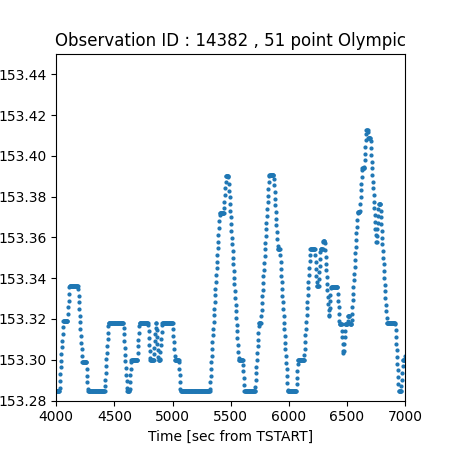

In [15]:
pset dmtabfilt dmtabfilt infile=fptemp.fits 
pset dmtabfilt out=temp_out
pset dmtabfilt col=fp_temp 
pset dmtabfilt function=olympic 
pset dmtabfilt mask="111111111111111111111111111111111111111111111111111"
dmtabfilt mode=h clob+
dmpaste fptemp.fits temp_out fp_temp_olympic51 clob+

PlotFile fp_temp_olympic51"[cols time,fp_temp_olympic]" chips_08.png ", 51 point Olympic"

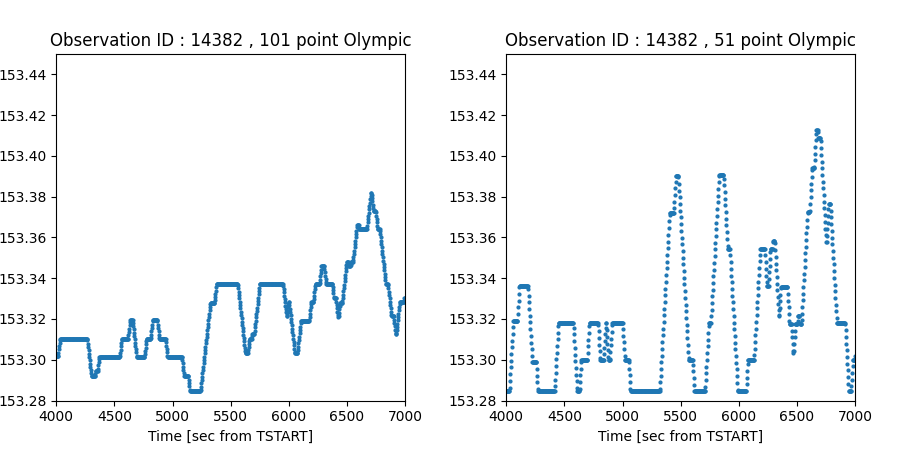

In [16]:
montage chips_07.png chips_08.png -geometry 450x450 dmtabfilt_1a.png  
display < dmtabfilt_1a.png

### Quantiles

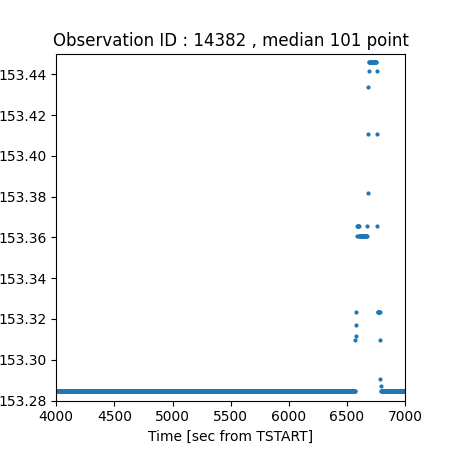

In [17]:
pset dmtabfilt infile=fptemp.fits 
pset dmtabfilt outfile=temp_out
pset dmtabfilt colname=fp_temp 
pset dmtabfilt function=median 
pset dmtabfilt mask=")101"
dmtabfilt mode=h clob+
dmpaste fptemp.fits temp_out fp_temp_median101 clob+

PlotFile fp_temp_median101"[cols time,fp_temp_median]" chips_09.png ", median 101 point"

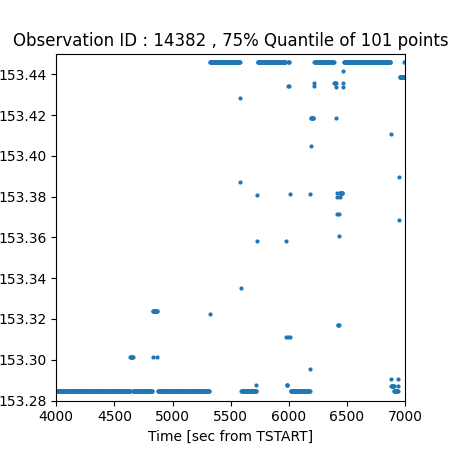

In [18]:
dmtabfilt in=fptemp.fits out=- col=fp_temp function=q75 mask=")101" | \
  dmpaste fptemp.fits - fp_temp_q75101 clob+

PlotFile fp_temp_q75101"[cols time,fp_temp_q75]" chips_10.png ", 75% Quantile of 101 points"

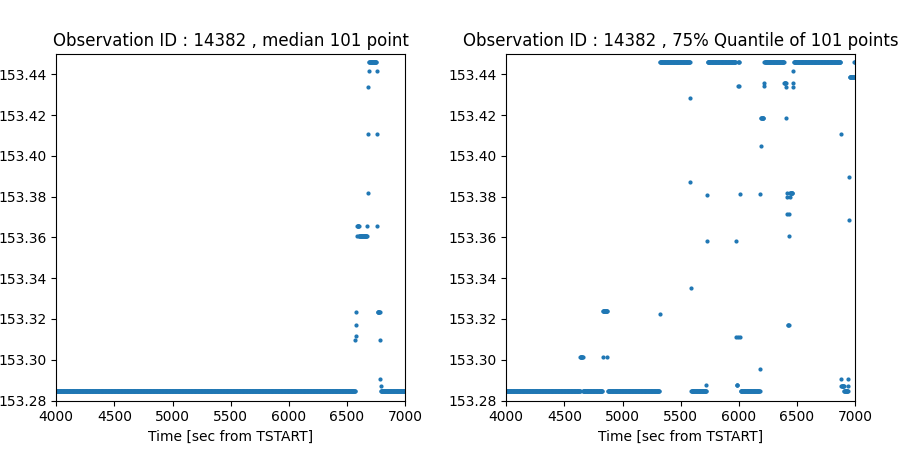

In [19]:
montage chips_09.png chips_10.png -geometry 450x450 dmtabfilt_1.png 
display < dmtabfilt_1.png

### Extreme

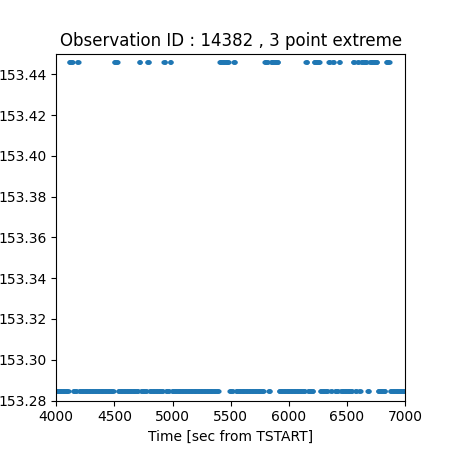

In [20]:
dmtabfilt in=fptemp.fits out=- col=fp_temp function=extreme mask="111" | \
  dmpaste fptemp.fits - fp_temp_extreme clob+ 

PlotFile fp_temp_extreme"[cols time,fp_temp_extreme]" chips_11.png ", 3 point extreme"

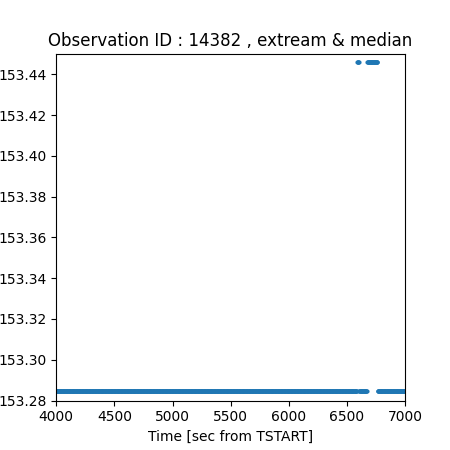

In [21]:
 dmtabfilt in=fptemp.fits out=- col=fp_temp function=extreme mask="111" | \
  dmtabfilt in=- out=- col=fp_temp_extreme function=median mask=")101" | \
  dmpaste fptemp.fits - fp_temp_extreme_median clob+ 

PlotFile fp_temp_extreme_median"[cols time,fp_temp_extreme_median]" chips_12.png ", extream & median"

In [22]:
montage chips_11.png chips_12.png -geometry 450x450 dmtabfilt_2.png
display < dmtabfilt_2.png

# Cleanup


In [23]:
/bin/rm -f acisf*
